# Imports and Functions

In [2]:
from sunlab.environment.base.cuda import *
from sunlab.environment.base.extras import *
from sunlab.globals import FILES
from sunlab.sunflow import *

In [3]:
from sunlab.sunflow.models_elu import AdversarialAutoencoder as AdversarialAutoencoderELU

In [4]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# Setup

## Model

In [5]:
try:
    del model
except:
    pass

In [7]:
dataset_file_name = FILES['TRAINING_DATASET']
test_dataset_files = [FILES['SPHEROID']['3mgml'],FILES['SPHEROID']['4mgml'],FILES['SPHEROID']['6mgml']]
model_directory = "../../test_models/autoencoder/"
normalization_scaler = MaxAbsScaler
distribution = GaussianDistribution
magnification = 10
latent_size = 2
batch_size = 1024
shuffle=True
val_split=0.1
autoencoder_depth = 3
use_leaky_relu = False
equal_split = True

In [8]:
dataset = import_dataset(dataset_file_name, magnification)
model = AdversarialAutoencoder(
    model_directory, distribution, normalization_scaler
).init(dataset.dataset, latent_size=latent_size, autoencoder_depth=autoencoder_depth, use_leaky_relu=False)
dataset = ShapeDataset(
    dataset_file_name,
    pre_scale=magnification,
    batch_size=batch_size,
    shuffle=shuffle,
    val_split=val_split,
    scaler=model.scaler,
    sort_columns=None,
    equal_split=equal_split,
)

In [9]:
test_datasets = [import_dataset(dataset, magnification, scaler=model.scaler) for dataset in test_dataset_files]
test_dataset = np.vstack([test_dataset.dataset for test_dataset in test_datasets])

In [9]:
test_dataset.shape

(13411, 13)

# Runtime Parameters

In [10]:
SAVE_EXTRAS = False

In [11]:
g_Base = lambda *args: DIR_ROOT + "Figures/AdversarialAutoencoderTesting/"

# Plots

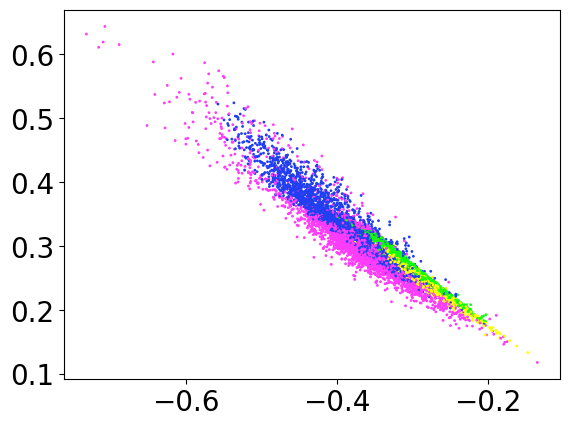

In [100]:
assert False
plt.scatter2d(model.encoder(dataset.dataset), cmap=Pmap, c=dataset.labels, s=1)
if SAVE_EXTRAS:
    plt.save(g_Base() + f"{_epochs}_D{autoencoder_depth}_{'LeakyReLU' if use_leaky_relu else 'ReLU'}")

# Results

In [13]:
classification_dataset_dict = np.load(DIR_ROOT + "extra_data/ClassificationTestingDataset.npy", allow_pickle=True).item()
classification_dataset = classification_dataset_dict['normalized_dataset']

In [28]:
dataset = import_dataset(dataset_file_name, magnification)
model = AdversarialAutoencoder(
    model_directory, distribution, normalization_scaler
).init(dataset.dataset, latent_size=latent_size, autoencoder_depth=autoencoder_depth, use_leaky_relu=False)
dataset = ShapeDataset(
    dataset_file_name,
    pre_scale=magnification,
    batch_size=batch_size,
    shuffle=shuffle,
    val_split=val_split,
    scaler=model.scaler,
    sort_columns=None,
    equal_split=equal_split,
)
training_dataset = model.scaler(dataset.training_data.copy())
validation_dataset = model.scaler(dataset.validation_data.copy())

In [29]:
training_dataset.shape, validation_dataset.shape

((11712, 13), (7767, 13))

In [56]:
dataScaler = model.scaler.scaler

In [34]:
training_data = []
training_classification_data = []

In [35]:
from tqdm.auto import tqdm

In [36]:
from itertools import product
import timeit
# for n_tests, epochs, autoencoder_depth, relu_type in product(range(3), [800,1600,2400],[1,2,3],range(3)):
for n_tests, epochs, autoencoder_depth, relu_type in tqdm(list(product(range(3), [1600],[1,2,3],range(1,3)))):
    timeit.default_timer()
    if relu_type == 0:
        # ReLU
        model = AdversarialAutoencoder(
            model_directory, distribution, normalization_scaler
        ).init(dataset.dataset, latent_size=latent_size, autoencoder_depth=autoencoder_depth, use_leaky_relu=False)
    elif relu_type == 1:
        # LeakyReLU
        model = AdversarialAutoencoder(
            model_directory, distribution, normalization_scaler
        ).init(dataset.dataset, latent_size=latent_size, autoencoder_depth=autoencoder_depth, use_leaky_relu=True)
    elif relu_type == 2:
        # ELU
        model = AdversarialAutoencoderELU(
            model_directory[:-1] + f"_{autoencoder_depth}_{relu_type}_{epochs}_{n_tests}", distribution, normalization_scaler
        ).init(dataset.dataset, latent_size=latent_size, autoencoder_depth=autoencoder_depth, use_leaky_relu=False)
    start_time = timeit.default_timer()
    _ = model.train(dataset, epochs, output=False)
    elapsed_train = timeit.default_timer() - start_time
    start_time = timeit.default_timer()
    run_this = model.encoder(dataset.dataset).numpy()
    elapsed_inference = timeit.default_timer() - start_time
    ae_t = np.abs(model.autoencoder(training_dataset).numpy() - training_dataset)
    ae_v = np.abs(model.autoencoder(validation_dataset).numpy() - validation_dataset)
    ae_T = np.abs(model.autoencoder(test_dataset).numpy() - test_dataset)
    mae_t = np.mean(ae_t)
    mae_v = np.mean(ae_v)
    mae_T = np.mean(ae_T)
    rmse_t = np.mean((np.mean(ae_t ** 2., axis=-1)) ** (1./2.))
    rmse_v = np.mean((np.mean(ae_v ** 2., axis=-1)) ** (1./2.))
    rmse_T = np.mean((np.mean(ae_T ** 2., axis=-1)) ** (1./2.))
    rmpe_t = np.mean((np.mean(ae_t ** 13., axis=-1)) ** (1./13.))
    rmpe_v = np.mean((np.mean(ae_v ** 13., axis=-1)) ** (1./13.))
    rmpe_T = np.mean((np.mean(ae_T ** 13., axis=-1)) ** (1./13.))
    training_data.append((relu_type, autoencoder_depth, epochs, elapsed_train, elapsed_inference,
                 mae_t, mae_v, mae_T,
                 rmse_t, rmse_v, rmse_T,
                 rmpe_t, rmpe_v, rmpe_T))
    training_classification_data.append(
        dataScaler.inverse_transform((model.autoencoder(classification_dataset).numpy()))
    )

  0%|          | 0/18 [00:00<?, ?it/s]

0[nan]: 4.08e-01 6.51e-01 1.14e+00  nan nan nan
0[nan]: 3.61e-01 7.44e-01 6.43e-01  nan nan nan
0[nan]: 3.55e-01 6.99e-01 6.75e-01  nan nan nan
0[nan]: 2.87e-01 7.67e-01 6.24e-01  nan nan nan
0[nan]: 3.47e-01 6.68e-01 8.86e-01  nan nan nan
0[nan]: 2.62e-01 6.86e-01 6.66e-01  nan nan nan
0[nan]: 3.36e-01 7.03e-01 6.32e-01  nan nan nan
0[nan]: 3.48e-01 6.74e-01 7.71e-01  nan nan nan
0[nan]: 3.31e-01 7.58e-01 6.49e-01  nan nan nan


In [37]:
assert False, "Don't overwrite"
np.save(f"../../classification_results_aae.npy", dict(results=np.array(training_classification_data)))

In [38]:
assert False, "Don't overwrite"
np.save(f"../../results_three_aae.npy", dict(results=training_data))

AssertionError: Don't overwrite

# Depth Checking

In [6]:
model = load_aae(FILES['PRETRAINED_MODEL_DIR'], MaxAbsScaler)

In [59]:
from scipy.spatial import KDTree

In [60]:
latent_vectors = model.encoder(dataset.dataset).numpy()
latent_vectors.shape

(19479, 2)

In [61]:
tree = KDTree(latent_vectors)

In [62]:
R = np.inf
# R = 0.05 # np.inf
N = 13*2 # latent_vectors.shape[0]
# N = 4 # latent_vectors.shape[0]

In [63]:
res = [tree.query(latent_vectors[dataset.labels==phenotype], N, distance_upper_bound=R) for phenotype in range(4)]

In [64]:
from tqdm.auto import tqdm

In [65]:
phenotype_neighbors = dict()
for phenotype in tqdm(range(4)):
    cells = np.argwhere(dataset.labels == phenotype)
    dists, indxs = res[phenotype]

    neighbors = {i: 0 for i in range(4)}
    for row in range(dists.shape[0]):
    #     cell = cells[row]
        classes = dataset.labels[indxs[row,~np.isinf(dists[row,...]).squeeze()]].astype(np.uint8)
        phenotypes, counts = np.unique(classes, return_counts=True)
        for i in range(phenotypes.shape[0]):
            neighbors[int(phenotypes[i])] += counts[i]

    phenotype_neighbors[phenotype] = neighbors
phenotype_neighbors

  0%|          | 0/4 [00:00<?, ?it/s]

{0: {0: 29682, 1: 3770, 2: 21036, 3: 21640},
 1: {0: 3760, 1: 86217, 2: 2889, 3: 19402},
 2: {0: 21019, 1: 2787, 2: 114836, 3: 9948},
 3: {0: 21690, 1: 18884, 2: 10155, 3: 118739}}

In [66]:
phenotype_names = ['ActinEdge', 'Filopodia', 'Bleb', 'Lamellipodia']

In [67]:
for phenotype in range(4):
    print(phenotype_names[phenotype])
    counts = list(phenotype_neighbors[phenotype].values())
    r = counts[phenotype]/sum(counts)
    print(counts)
    print(r*100)

ActinEdge
[29682, 3770, 21036, 21640]
38.98959646910466
Filopodia
[3760, 86217, 2889, 19402]
76.79570313891759
Bleb
[21019, 2787, 114836, 9948]
77.28380106332862
Lamellipodia
[21690, 18884, 10155, 118739]
70.06573512403521


In [68]:
for phenotype in range(4):
    print(phenotype_names[phenotype])
    counts = list(phenotype_neighbors[phenotype].values())
    fixed_normalization = (2*counts[phenotype]-sum(counts))/N
    phenotype_relative_normalization = (2*counts[phenotype]-sum(counts))/np.sum(dataset.labels==phenotype)
    print(counts)
    print(fixed_normalization)
    print(phenotype_relative_normalization)

ActinEdge
[29682, 3770, 21036, 21640]
-644.7692307692307
-5.725409836065574
Filopodia
[3760, 86217, 2889, 19402]
2314.076923076923
13.933765632237147
Bleb
[21019, 2787, 114836, 9948]
3118.5384615384614
14.187576552930883
Lamellipodia
[21690, 18884, 10155, 118739]
2615.769230769231
10.434182264498313


<module 'matplotlib.pyplot' from '/home/physics/cunnichr/.conda/envs/tfnb/lib/python3.9/site-packages/matplotlib/pyplot.py'>

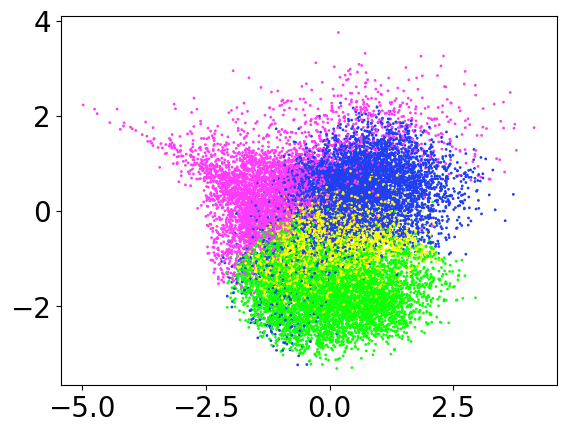

In [69]:
plt.scatter2d(latent_vectors, c=dataset.labels, cmap=Pmap, s=1)

# Depth Checking - Untransformed

In [70]:
from scipy.spatial import KDTree

In [71]:
latent_vectors = dataset.dataset
latent_vectors.shape

(19479, 13)

In [72]:
tree = KDTree(latent_vectors)

In [73]:
R = np.inf
# R = 0.05 # np.inf
N = 13*2 # latent_vectors.shape[0]
# N = 4 # latent_vectors.shape[0]

In [74]:
res = [tree.query(latent_vectors[dataset.labels==phenotype], N, distance_upper_bound=R) for phenotype in range(4)]

In [75]:
from tqdm.auto import tqdm

In [76]:
phenotype_neighbors = dict()
for phenotype in tqdm(range(4)):
    cells = np.argwhere(dataset.labels == phenotype)
    dists, indxs = res[phenotype]

    neighbors = {i: 0 for i in range(4)}
    for row in range(dists.shape[0]):
    #     cell = cells[row]
        classes = dataset.labels[indxs[row,~np.isinf(dists[row,...]).squeeze()]].astype(np.uint8)
        phenotypes, counts = np.unique(classes, return_counts=True)
        for i in range(phenotypes.shape[0]):
            neighbors[int(phenotypes[i])] += counts[i]

    phenotype_neighbors[phenotype] = neighbors
phenotype_neighbors

  0%|          | 0/4 [00:00<?, ?it/s]

{0: {0: 50753, 1: 2990, 2: 9812, 3: 12573},
 1: {0: 3288, 1: 93681, 2: 2582, 3: 12717},
 2: {0: 7208, 1: 1681, 2: 131621, 3: 8080},
 3: {0: 11085, 1: 10306, 2: 10834, 3: 137243}}

In [77]:
phenotype_names = ['ActinEdge', 'Filopodia', 'Bleb', 'Lamellipodia']

In [78]:
for phenotype in range(4):
    print(phenotype_names[phenotype])
    counts = list(phenotype_neighbors[phenotype].values())
    r = counts[phenotype]/sum(counts)
    print(counts)
    print(r*100)

ActinEdge
[50753, 2990, 9812, 12573]
66.66798024379992
Filopodia
[3288, 93681, 2582, 12717]
83.44408023657677
Bleb
[7208, 1681, 131621, 8080]
88.57998519415841
Lamellipodia
[11085, 10306, 10834, 137243]
80.98461066396015


In [79]:
for phenotype in range(4):
    print(phenotype_names[phenotype])
    counts = list(phenotype_neighbors[phenotype].values())
    fixed_normalization = (2*counts[phenotype]-sum(counts))/N
    phenotype_relative_normalization = (2*counts[phenotype]-sum(counts))/np.sum(dataset.labels==phenotype)
    print(counts)
    print(fixed_normalization)
    print(phenotype_relative_normalization)

ActinEdge
[50753, 2990, 9812, 12573]
976.0769230769231
8.667349726775956
Filopodia
[3288, 93681, 2582, 12717]
2888.230769230769
17.39092172301992
Bleb
[7208, 1681, 131621, 8080]
4409.692307692308
20.06159230096238
Lamellipodia
[11085, 10306, 10834, 137243]
4039.153846153846
16.111997545259282


<module 'matplotlib.pyplot' from '/home/physics/cunnichr/.conda/envs/tfnb/lib/python3.9/site-packages/matplotlib/pyplot.py'>

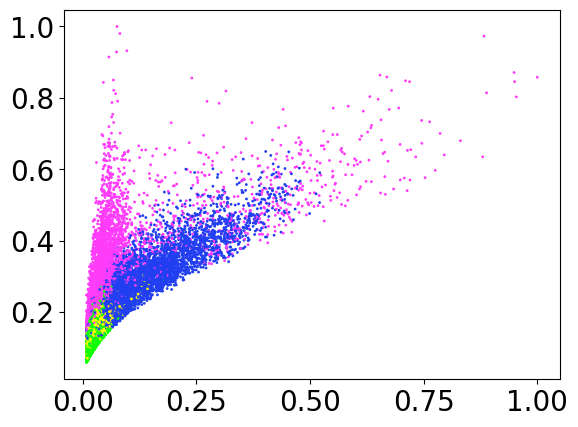

In [80]:
plt.scatter2d(latent_vectors, c=dataset.labels, cmap=Pmap, s=1)

# END